The following code uses a Gibbs sampler to obtain updated Bayesian distributions on the mean and variance of the exam scores in the file examscores.csv.

In [14]:
%matplotlib inline
import numpy as np
from scipy.special import gammaln
from math import sqrt
from scipy.stats import norm, invgamma, gaussian_kde
import matplotlib.pyplot as plt
import string

def gibbs(y, mu0, sigma02, alpha, beta, n_samples):
    """
    Assuming a likelihood and priors
    y_i
    ~ N(mu, sigma2),
    mu
    ~ N(mu0, sigma02),
    sigma2 ~ IG(alpha, beta),
    sample from the posterior distribution
    P(mu, sigma2 | y, mu0, sigma02, alpha, beta)
    using a gibbs sampler.
    Parameters
    ----------
    y : ndarray of shape (N,)
    The data
    mu0 : float
    The prior mean parameter for mu
    sigma02 : float > 0
    The prior variance parameter for mu
    alpha : float > 0
    The prior alpha parameter for sigma2
    beta : float > 0
    The prior beta parameter for sigma2
    n_samples : int
    The number of samples to draw
    Returns
    -------
    samples : ndarray of shape (n_samples,2)
    1st col = mu samples, 2nd col = sigma2 samples
    """
    samples = np.zeros((n_samples , 2))
    sample = np.array([mu0, sigma02])
    talpha, tbeta = alpha, beta
    N = y.size
    mu = norm.rvs(mu0, scale = sqrt(sigma02))
    sigma2 = invgamma.rvs(alpha, scale = beta)
    for i in xrange(n_samples):
        alpha_star = alpha + N/2.
        beta_star = beta + 1./2 * np.sum((y-mu)**2)

        #sample sigma
        sigma2 = invgamma.rvs(alpha_star, scale = beta_star)

        sig2_star = 1 / (1./sigma02 + N/sigma2)
        mu_star = sig2_star * (mu0/sigma02 + 1/sigma2 * np.sum(y))

        #sample mu
        mu = norm.rvs(mu_star, scale = sqrt(sig2_star))
        samples[i, :] = np.array([mu, sigma2])

    return samples


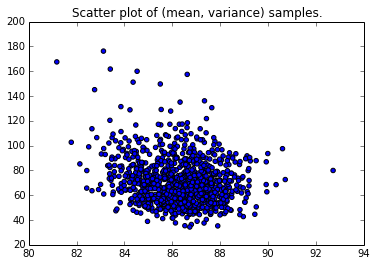

In [15]:
y = np.loadtxt("examscores.csv")
mu0, sig2 = 80, 16
alpha, beta = 3, 50
samples = gibbs(y, mu0, sig2, alpha, beta, 1000)
mu_samples = samples[:,0]
sig2_samples = samples[:,1]
plt.scatter(mu_samples , sig2_samples)
plt.title("Scatter plot of (mean, variance) samples.")
plt.show()


Given a bunch of samples of the mean and variance, we'd like to visualize the posteroir distributions on the mean and variance. This is accomplished by using a kernel density estimator, which is conveniently implemented as gaussian_kde in scipy.stats for us.

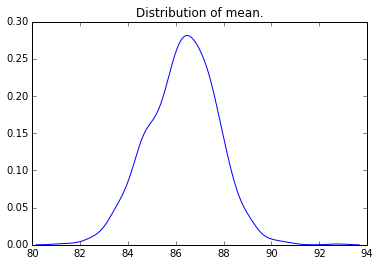

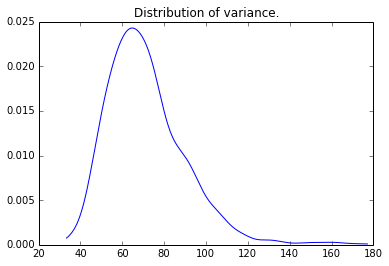

In [16]:
def plot_kernel(arr, step = .1, title=""):
    kernel = gaussian_kde(arr)
    x_min, x_max = min(arr)-1, max(arr) + 1
    dom = np.arange(x_min, x_max, step)
#    print dom, x_min, x_max, arr
    plt.plot(dom, kernel(dom))
    plt.title(title)
    plt.show()

plot_kernel(mu_samples, title="Distribution of mean.")
plot_kernel(sig2_samples, title="Distribution of variance.")


In order to obtain the posterior distribution on the actual scores, we simply sample one score for each sample mean and variance, and then plot the resulting distribution, again using a kernel density estimator.

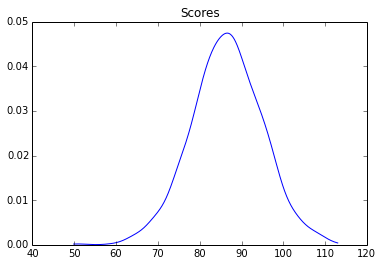

In [17]:
n_samples = mu_samples.size
yvals = np.zeros(n_samples)
for i in xrange(n_samples):
    yvals[i] = norm.rvs(mu_samples[i], scale = sqrt(sig2_samples[i]))

plot_kernel(yvals, title="Scores")

In [18]:
def loadStopwords(filename):
    """ This function is given. """
    infile = open(filename,'r')
    stopwords = infile.readlines()
    for i in xrange(len(stopwords)):
        stopwords[i] = stopwords[i].rstrip()
    stopwords.append('')
    return stopwords

class LDACGS(object):

    def __init__(self, n_topics, alpha = 0.1, beta = 0.1):
        """ This function is given. """
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta

    def buildCorpus(self,filename,stopwords=None):
        """ This function is given. """
        infile = open(filename,'r')
        doclines = [line.rstrip().translate(string.maketrans("",""),string.punctuation).lower().split(' ') for line in infile]
        n_docs = len(doclines)
        self.vocab = []
        for i in xrange(n_docs):
            self.vocab += doclines[i]
        self.vocab = list(set(self.vocab))
        if stopwords != None:
            self.vocab = np.sort(self._removeStopwords(stopwords)).tolist()
        self.documents = []
        for i in xrange(n_docs):
            self.documents.append({})
            for j in xrange(len(doclines[i])):
                if doclines[i][j] in self.vocab:
                    self.documents[i][j] = self.vocab.index(doclines[i][j])

    def inc_mats(self, topic, doc, word):
        self.nz[topic] += 1
        self.nmz[doc, topic] += 1
        self.nzw[topic, word] += 1

    def dec_mats(self, topic, doc, word):
        self.nz[topic] -= 1
        self.nmz[doc, topic] -= 1
        self.nzw[topic, word] -= 1


    def initialize(self):
        self.n_words = len(self.vocab)
        self.n_docs = len(self.documents)

        # initialize the three count matrices
        # the (i,j) entry of self.nmz is # of words in document i assigned to topic j
        self.nmz = np.zeros((self.n_docs,self.n_topics))
        # the (i,j) entry of self.nzw is # of times term j is assigned to topic i
        self.nzw = np.zeros((self.n_topics,self.n_words))
        # the (i)-th entry is the number of times topic i is assigned in the corpus
        self.nz = np.zeros(self.n_topics)

        # initialize the topic assignment dictionary
        self.topics = {} # key-value pairs of form (m,i):z
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Get random topic assignment, i.e. z = ...
                topic = np.random.randint(0,self.n_topics)

                # Increment count matrices
                word = self.documents[m][i]
                self.inc_mats(topic, m, word)
                # Store topic assignment, i.e. self.topics[(m,i)]=z
                self.topics[(m,i)] = topic

    def sample(self,filename, burnin=100, sample_rate=10, n_samples=10, stopwords=None):
        self.buildCorpus(filename,stopwords)
        self.initialize()
        self.total_nzw = np.zeros((self.n_topics,self.n_words))
        self.total_nmz = np.zeros((self.n_docs,self.n_topics))
        self.logprobs = np.zeros(burnin + sample_rate*n_samples)
        for i in xrange(burnin):
            # Sweep and store log likelihood
            self._sweep()
            self.logprobs[i] = self._loglikelihood()

        for i in xrange(n_samples*sample_rate):
                # Sweep and store log likelihood
            self._sweep()
            self.logprobs[burnin+i] = self._loglikelihood()
            if not i%sample_rate:
                continue
            # accumulate counts every sample_rate samples
            self.total_nzw += self.nzw
            self.total_nmz += self.nmz

    def phi(self):
        """ This function is given. """
        phi = self.total_nzw + self.beta
        self._phi = phi / np.sum(phi, axis=1)[:,np.newaxis]

    def theta(self):
        """ This function is given. """
        theta = self.total_nmz + self.alpha
        self._theta = theta / np.sum(theta, axis=1)[:,np.newaxis]

    def topterms(self,n_terms=10):
        """ This function is given. """
        vec = np.atleast_2d(np.arange(0,self.n_words))
        topics = []
        self.phi()
        for k in xrange(self.n_topics):
            probs = np.atleast_2d(self._phi[k,:])
            mat = np.append(probs,vec,0)
            sind = np.array([mat[:,i] for i in np.argsort(mat[0])]).T
            topics.append([self.vocab[int(sind[1,self.n_words - 1 - i])] for i in xrange(n_terms)])
        return topics

    def toplines(self,n_lines=5):
        """ This function is given. """
        lines = np.zeros((self.n_topics,n_lines))
        for i in xrange(self.n_topics):
            args = np.argsort(self._theta[:,i]).tolist()
            args.reverse()
            lines[i,:] = np.array(args)[0:n_lines] + 1
        return lines

    def _removeStopwords(self,stopwords):
        """ This function is given. """
        output = []
        for x in self.vocab:
            if x not in stopwords:
                output.append(x)
        return output

    def _conditional(self, m, w):
        """
        This function is given. Compute the conditional distribution of
        the topic corresponding to document m and word index w.
        Returns a distribution vector of length self.n_topics.
        """
        dist = (self.nmz[m,:] + self.alpha) * (self.nzw[:,w] + self.beta) / (self.nz + self.beta*self.n_words)
        return dist/sum(dist)

    def _sweep(self):
        for m in xrange(self.n_docs):
            for i in self.documents[m]:
                # Retrieve vocab index for i^th word in document m
                word = self.documents[m][i]
                # Retrieve topic assignment for i^th word in document m
                topic = self.topics[(m,i)]
                # Decrement count matrices
                self.dec_mats(topic, m, word)
                # Get conditional distribution
                topic_dist = self._conditional(m,word)
                # Sample new topic assignment
                new_topic = np.random.multinomial(1,topic_dist)[0]
                # Increment count matrices
                self.inc_mats(new_topic, m, word)
                # Store new topic assignment
                self.topics[(m, i)] = new_topic


    def _loglikelihood(self):
        """ This function is given. """
        lik = 0

        for z in xrange(self.n_topics):
            lik += np.sum(gammaln(self.nzw[z,:] + self.beta)) - gammaln(np.sum(self.nzw[z,:] + self.beta))
            lik -= self.n_words * gammaln(self.beta) - gammaln(self.n_words*self.beta)

        for m in xrange(self.n_docs):
            lik += np.sum(gammaln(self.nmz[m,:] + self.alpha)) - gammaln(np.sum(self.nmz[m,:] + self.alpha))
            lik -= self.n_topics * gammaln(self.alpha) - gammaln(self.n_topics*self.alpha)

        return lik


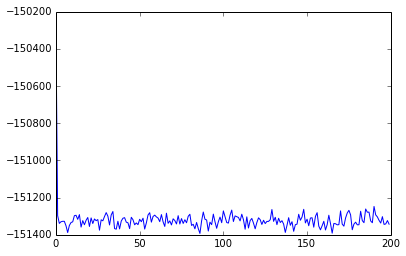

In [19]:
l = LDACGS(20)
stopwords = loadStopwords("stopwords.txt")
l.sample("reagan.txt", stopwords = stopwords)
plt.plot(l.logprobs)
plt.show()


In [20]:
l.topterms(10)

[['people',
  'america',
  'government',
  'years',
  'american',
  'federal',
  'freedom',
  'world',
  'year',
  'tax'],
 ['people',
  'america',
  'government',
  'years',
  'american',
  'federal',
  'freedom',
  'year',
  'world',
  'tax'],
 ['zooming',
  'exceed',
  'everyones',
  'evidence',
  'exact',
  'exaggerated',
  'examine',
  'examined',
  'excellence',
  'evergrowing'],
 ['zooming',
  'exceed',
  'everyones',
  'evidence',
  'exact',
  'exaggerated',
  'examine',
  'examined',
  'excellence',
  'evergrowing'],
 ['zooming',
  'exceed',
  'everyones',
  'evidence',
  'exact',
  'exaggerated',
  'examine',
  'examined',
  'excellence',
  'evergrowing'],
 ['zooming',
  'exceed',
  'everyones',
  'evidence',
  'exact',
  'exaggerated',
  'examine',
  'examined',
  'excellence',
  'evergrowing'],
 ['zooming',
  'exceed',
  'everyones',
  'evidence',
  'exact',
  'exaggerated',
  'examine',
  'examined',
  'excellence',
  'evergrowing'],
 ['zooming',
  'exceed',
  'everyones',

Interestingly, using the stopwords filter, I get only two topics. One of them appears to be about world and national politics, with such keywords as america, tax, and government. The others appear to be 